In [ ]:
#!/usr/bin/env python
# coding: utf-8
!pip install nltk
!pip install praw
!pip install matplotlib
!pip install datetime

import warnings
warnings.filterwarnings("ignore", message="WARNING:praw:It appears that you are using PRAW in an asynchronous environment. \n It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io. \n See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.")

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import praw
import matplotlib.pyplot as plt
import math
import datetime as dt
import pandas as pd
import numpy as np

nltk.download('vader_lexicon')    
nltk.download('stopwords')    

# Link to developer account
reddit = praw.Reddit(
    client_id="L7QPqVJ0FGSinh6H1MpQNA",
    client_secret="kE1i7eYbk_zskLuxf73q6uyhkKXycQ",
    password="123456Pass_@-Q",
    user_agent="my user agent",
    username="Jiasuanna",
)



In [2]:

def commentSentiment(ticker, urlT):
    """
    To grasp sentiment average score for comments
    Extract info from urlT which directs to a post which mentiones the ticker in a subreddit.
    """
    subComments = []
    bodyComment = []
    try:
        check = reddit.submission(url=urlT)
        subComments = check.comments
    except:
        return 0 
    
    for comment in subComments:
        try: 
            bodyComment.append(comment.body)
        except:
            return 0
    

    sia = SIA() # SentimentIntensityAnalyzer
    results = []
    for line in bodyComment: 
        scores = sia.polarity_scores(line)
        scores['headline'] = line 
        results.append(scores)
    
    df = pd.DataFrame.from_records(results) 

    df['label'] = 0 
    try:
        df.loc[df['compound'] > 0.1, 'label'] = 1 # positive sentiment 
        df.loc[df['compound'] < -0.1, 'label'] = -1 # negative sentiment
    except:
        return 0 # nutural otherwise
    

    # To compute the average scores of all commnets for the post directed by the url
    averageScore = 0
    position = 0 
    while position < len(df.label)-1:
        averageScore = averageScore + df.label[position]
        position += 1
    averageScore = averageScore/len(df.label)
    
    return averageScore
    

def latestComment(ticker, urlT):
    """
    Find the latest comment through a given url
    """
    subComments = []
    updateDates = []
    try:
        check = reddit.submission(url=urlT)
        subComments = check.comments
    except:
        return 0
    
    for comment in subComments:
        try: 
            updateDates.append(comment.created_utc)
        except:
            return 0
    
    updateDates.sort()
    return(updateDates[-1])


def get_date(date):
    return dt.datetime.fromtimestamp(date)


In [3]:
# focues on subreddit 'wallstreetbets', and examine and trade stocks like "GME", "AMC", "TSLA"
sub_reddit = "wallstreetbets"
stocks = ["GME", "AMC", "TSLA"] 


# Creating a dataframe to record info from r/wallstreetbets that mentioned stocks that we wanna be looking at, here are ["GME", "AMC", "TSLA"] 
submission_statistics = []
d = {}
for ticker in stocks:
    for submission in reddit.subreddit(sub_reddit).search(ticker, limit=130): # to output the most recent 130 post mentioned the tickers
        if submission.domain != "self."+sub_reddit:
            continue
        d = {}
        d['ticker'] = ticker
        d['num_comments'] = submission.num_comments
        d['comment_sentiment_average'] = commentSentiment(ticker, submission.url)
        if d['comment_sentiment_average'] == 0.000000:
            continue
        d['latest_comment_date'] = latestComment(ticker, submission.url)
        d['score'] = submission.score
        d['upvote_ratio'] = submission.upvote_ratio
        d['date'] = submission.created_utc
        d['domain'] = submission.domain
        d['num_crossposts'] = submission.num_crossposts
        d['author'] = submission.author
        submission_statistics.append(d)
    
dfSentimentStocks = pd.DataFrame(submission_statistics) 

_timestampcreated = dfSentimentStocks["date"].apply(get_date)
dfSentimentStocks = dfSentimentStocks.assign(timestamp = _timestampcreated)

_timestampcomment = dfSentimentStocks["latest_comment_date"].apply(get_date)
dfSentimentStocks = dfSentimentStocks.assign(commentdate = _timestampcomment)


# plotting

tickers = []
for t in stocks:
    posts_sentiment = dfSentimentStocks.loc[dfSentimentStocks.ticker == t].comment_sentiment_average
    tickers += [posts_sentiment]

stock_sentiment = []
for ind in tickers:
    sentiment = [0,0,0] #positive, neutural, negative
    for i in ind:
        if i > 0.05:
            sentiment[0] += 1
        elif i < - 0.05:
            sentiment[2] += 1
        else:
            sentiment[1] += 1
    stock_sentiment += [sentiment]

length = len(stock_sentiment)


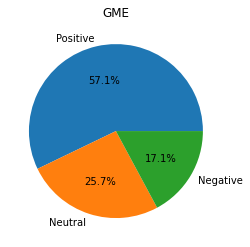

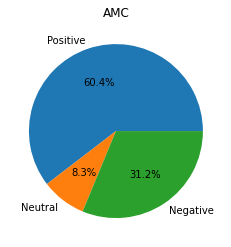

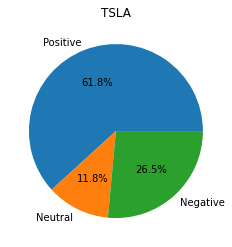

In [4]:
for i in range(length):
    labels = ["Positive", "Neutral","Negative"]
    plt.pie(stock_sentiment[i], labels = labels, autopct="%1.1f%%")
    plt.title(stocks[i])
    plt.show()

In [5]:
# Cryptocurriencies

In [6]:
# focues on subreddit 'CryptoCurrency', and examine and cryptocurrencies like "Bitcoin", "Ethereum", "Tether"
sub_reddit = "CryptoCurrency"
cryptos = ["Bitcoin", "Ethereum", "Tether"] 

submission_statistics = []
d = {}
for ticker in cryptos:
    for submission in reddit.subreddit(sub_reddit).search(ticker, limit=130): # to output the most recent 130 post mentioned the tickers
        if submission.domain != "self."+sub_reddit:
            continue
        d = {}
        d['ticker'] = ticker
        d['num_comments'] = submission.num_comments
        d['comment_sentiment_average'] = commentSentiment(ticker, submission.url)
        if d['comment_sentiment_average'] == 0.000000:
            continue
        d['latest_comment_date'] = latestComment(ticker, submission.url)
        d['score'] = submission.score
        d['upvote_ratio'] = submission.upvote_ratio
        d['date'] = submission.created_utc
        d['domain'] = submission.domain
        d['num_crossposts'] = submission.num_crossposts
        d['author'] = submission.author
        submission_statistics.append(d)
    
dfSentimentCryptos = pd.DataFrame(submission_statistics) 

_timestampcreated = dfSentimentCryptos["date"].apply(get_date)
dfSentimentCryptos = dfSentimentCryptos.assign(timestamp = _timestampcreated)

_timestampcomment = dfSentimentCryptos["latest_comment_date"].apply(get_date)
dfSentimentCryptos = dfSentimentCryptos.assign(commentdate = _timestampcomment)


# plotting

tickers = []
for t in cryptos:
    posts_sentiment = dfSentimentCryptos.loc[dfSentimentCryptos.ticker == t].comment_sentiment_average
    tickers += [posts_sentiment]

Crypto_sentiment = []
for ind in tickers:
    sentiment = [0,0,0] #positive, neutural, negative
    for i in ind:
        if i > 0.05:
            sentiment[0] += 1
        elif i < - 0.05:
            sentiment[2] += 1
        else:
            sentiment[1] += 1
    Crypto_sentiment += [sentiment]

length = len(Crypto_sentiment)


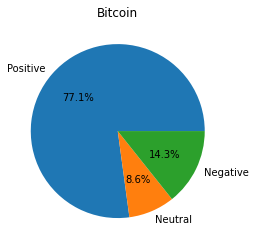

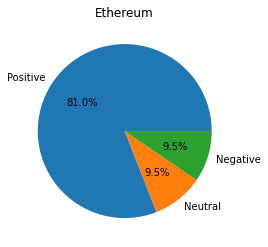

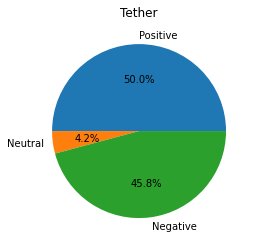

In [7]:
for i in range(length):
    labels = ["Positive", "Neutral","Negative"]
    plt.pie(Crypto_sentiment[i], labels = labels, autopct="%1.1f%%")
    plt.title(cryptos[i])
    plt.show()